# Backtrader Defensive Investor Simulation - all 14,000 companies - v1
**Purpose.** The purpose of this notebook is to simulate the application of Ben Graham's *Defensive Investor's criteria (as described in Chapter 14 of Intelligent Investor)* in a portfolio strategy over the past 10 years. 

**Pre-work.** This notebook builds on output saved on disk, to speed up the process - the following steps are very time-consuming:
1. [Download Quandl data to apply Defensive Investor's criteria](http://localhost:8888/notebooks/Download%20Quandl%20data%20to%20apply%20Defensive%20Investor's%20criteria.ipynb) saves fundamentals data from all 14,121 companies in Quandl Sharadar/SF1 database needed to apply defensive investor's test in a CSV file, to be used in step 2.
2. [Evolution of companies meeting Defensive Investor criteria over time](http://localhost:8888/notebooks/Evolution%20of%20companies%20meeting%20Defensive%20Investor%20criteria%20over%20time.ipynb) saves all companies passing the first 5 criteria in a pickle file (the last 2 criteria will be tested in this notebook), to be used in step 3 and in this notebook.
3. [Download Daily Prices, PE & PB data from all companies passing Defensive Investor Criteria](http://localhost:8888/notebooks/Download%20Daily%20Prices%2C%20PE%20%26%20PB%20data%20from%20all%20companies%20passing%20Defensive%20Investor%20Criteria.ipynb) saves daily prices, PE and PB ratios from the list in previous step in a CSV file, to be used in this notebook.

## Step 1: Load all pre-processed data needed to run the simulation

In [175]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import quandl
import pandas_datareader as pdr
from datetime import datetime, timedelta
import calendar
import backtrader as bt
import backtrader.feeds as btfeeds
import backtrader.analyzers as btanalyzers
import matplotlib.pyplot as plt
import pickle
from graham import *

quandl.ApiConfig.api_key = os.getenv('QUANDL_APY_KEY')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
fname_companies = os.path.join(os.getcwd(), 'data_defensive', 'defensive1_companies_20081231_20181231.pkl')
fname_pricedata = os.path.join(os.getcwd(), 'data_defensive', 'defensive1_pricedata_20081231_20181231.csv')

In [177]:
def load_obj(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
dc_companies = load_obj(fname_companies)
df_pricedata = pd.read_csv(fname_pricedata, index_col=0, parse_dates=['date'])

In [178]:
def get_trading_data(ticker):
    df = df_pricedata[df_pricedata['ticker'] == ticker][['date', 'open', 'high', 'low', 'close', 'volume', 'pe', 'pb']]
    df.set_index('date', inplace=True)
    return df

There might be companies which pass the test criteria, but without trading data. The code below fix it, removing these companies:

In [179]:
all_companies_passing_in_period = set()
for key, value in dc_companies.items():
    for el in value:
        all_companies_passing_in_period.add(el)
        
all_companies_passing_in_period = list(all_companies_passing_in_period)

for ticker in all_companies_passing_in_period:
    data = get_trading_data(ticker)
    if (data.shape[0] == 0):
        print(f'Problem with {ticker}: pass the criteria, but does not have all trading data. Removing it.')
        all_companies_passing_in_period.remove(ticker)
        for key, value in dc_companies.items():
            if ticker in value:
                value.remove(ticker)
                
for ticker in all_companies_passing_in_period:
    data = get_trading_data(ticker)
    if (data.index[-1] != get_trading_data('NKE').index[-1]):
        print(f'Problem with {ticker}: pass the criteria, but does not have all trading data. Removing it.')
        all_companies_passing_in_period.remove(ticker)
        for key, value in dc_companies.items():
            if ticker in value:
                value.remove(ticker)

Problem with ABI1: pass the criteria, but does not have all trading data. Removing it.
Problem with CNL: pass the criteria, but does not have all trading data. Removing it.
Problem with LNCE: pass the criteria, but does not have all trading data. Removing it.
Problem with AMN1: pass the criteria, but does not have all trading data. Removing it.
Problem with KDN: pass the criteria, but does not have all trading data. Removing it.
Problem with CSH: pass the criteria, but does not have all trading data. Removing it.
Problem with CLC: pass the criteria, but does not have all trading data. Removing it.
Problem with LLTC: pass the criteria, but does not have all trading data. Removing it.
Problem with BCR: pass the criteria, but does not have all trading data. Removing it.
Problem with SIAL: pass the criteria, but does not have all trading data. Removing it.
Problem with APAGF: pass the criteria, but does not have all trading data. Removing it.
Problem with PCP: pass the criteria, but does n

Now we can continue. Let's check the data we pulled.

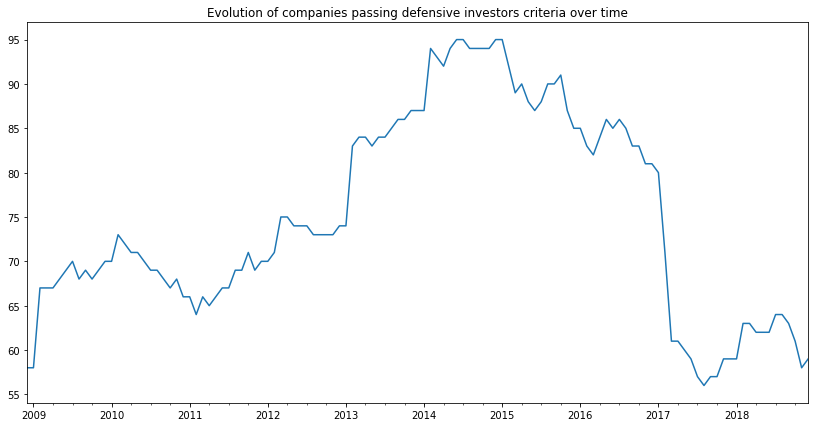

In [180]:
df = pd.DataFrame(columns=['companies_passing'], index=dc_companies.keys())
for key, value in dc_companies.items():
    df.at[key, 'companies_passing'] = len(value)

df['perc_companies_passing'] = df['companies_passing'] / 14121    
df['companies_passing'].plot(figsize=(14, 7), 
                                  title='Evolution of companies passing defensive investors criteria over time')

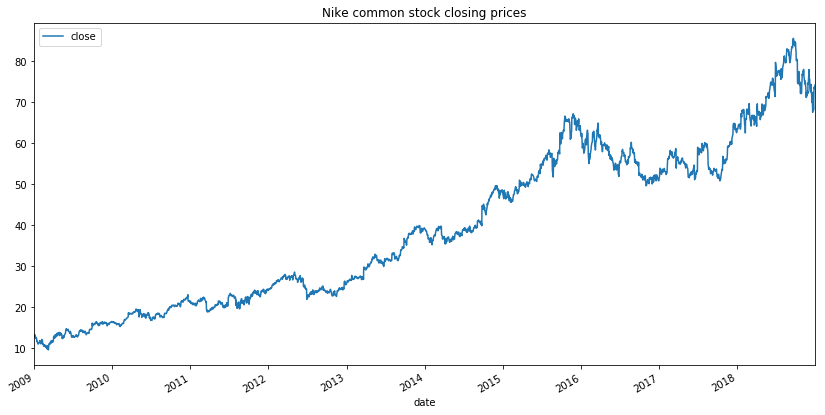

In [181]:
get_trading_data('NKE')[['close']].plot(figsize=(14, 7), title='Nike common stock closing prices')

## Step 2: Define the trading strategy

It is very important to retrieve companies passing the criteria for a given date. Let's do it:

In [182]:
def get_passing_companies(date):
    month_ago = date - timedelta(365 / 12)
    year = month_ago.year
    month = month_ago.month
    day = calendar.monthrange(year, month)[1]
    closest_last_month = datetime(year, month, day)
    return dc_companies[closest_last_month]

In [183]:
#get_passing_companies(datetime(2009, 1, 15))
#get_trading_data('ABI1')

Now we are ready to implement the strategy:

In [198]:
class TestStrategy(bt.Strategy):
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        #print(self.getdatanames())
        self.cash = 0
        self.order = None
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY {order.data.params.name} EXECUTED, Price: {order.executed.price:.2f}, Amount: {order.executed.size:.2f}, PE: {order.data.pe[0]}')
            elif order.issell():
                self.log(f'SELL {order.data.params.name} EXECUTED, Price: {order.executed.price:.2f}, Amount: {order.executed.size:.2f}, PE: {order.data.pe[0]}')

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        for ticker in get_passing_companies(self.datas[0].datetime.date(0)):
            line = self.dnames[ticker]
            if self.getposition(line).size == 0:
                if line.pe[0] < 15 and line.pe[0] > 0:
                    #if (line.pb[0] < 1.5) or (line.pe[0] * line.pb[0] < 22.5):
                        #self.log(f"{ticker} BUY opportunity at {line.close[0]}, PE {line.pe[0]}")
                    self.order = self.buy(data=line, size=int(1000.0 / line.close[0]))
            #else:
                #if line.pe[0] > 40:
                    #self.log(f"{ticker} SELL opportunity at {line.close[0]}, PE {line.pe[0]}")
                    #self.order = self.sell(data=line, size=self.getposition(line).size)
        

## Step 3: Run the strategy

In [199]:
class PandasDataPEPB(btfeeds.PandasData):
    lines = ('pe', 'pb', )
    params = (('pe', -1), ('pb', -1), ) # ('name', 'teste'), )

In [200]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy)

# Add all data
for ticker in all_companies_passing_in_period: #[:10]:
    data = PandasDataPEPB(dataname=get_trading_data(ticker), name=ticker)
    cerebro.adddata(data)

In [201]:
a = datetime.now()

cerebro.broker.setcash(200000.0)

# Adding analyzers
cerebro.addanalyzer(btanalyzers.AnnualReturn, _name='ar')
cerebro.addanalyzer(btanalyzers.TimeReturn, _name='tr')
#cerebro.addobserver(bt.observers.Value)

# Print out the starting conditions
initial_value = cerebro.broker.getvalue()
print(f'Starting Portfolio Value: {initial_value:,}')

# Run over everything
thestrats = cerebro.run()
thestrat = thestrats[0]

# Print out the final result
final_value = cerebro.broker.getvalue()
print(f'Final Portfolio Value: {final_value:,}')

print(f'\nTime to execute: {(datetime.now() - a)}')

Starting Portfolio Value: 200,000.0
2009-01-02, BUY ACET EXECUTED, Price: 10.04, Amount: 99.00, PE: 14.8
2009-01-02, BUY AIT EXECUTED, Price: 19.00, Amount: 52.00, PE: 9.1
2009-01-02, BUY ALB EXECUTED, Price: 22.24, Amount: 44.00, PE: 8.8
2009-01-02, BUY ASH EXECUTED, Price: 5.28, Amount: 190.00, PE: 2.1
2009-01-02, BUY BDX EXECUTED, Price: 68.59, Amount: 14.00, PE: 15.1
2009-01-02, BUY BEN EXECUTED, Price: 21.29, Amount: 47.00, PE: 9.8
2009-01-02, BUY BMS EXECUTED, Price: 24.06, Amount: 42.00, PE: 14.0
2009-01-02, BUY BRC EXECUTED, Price: 23.97, Amount: 41.00, PE: 9.6
2009-01-02, BUY CRR EXECUTED, Price: 35.69, Amount: 28.00, PE: 14.7
2009-01-02, BUY CSL EXECUTED, Price: 20.67, Amount: 48.00, PE: 15.3
2009-01-02, BUY CTAS EXECUTED, Price: 23.23, Amount: 43.00, PE: 11.0
2009-01-02, BUY EBF EXECUTED, Price: 12.11, Amount: 82.00, PE: 7.7
2009-01-02, BUY EML EXECUTED, Price: 8.60, Amount: 116.00, PE: 12.3
2009-01-02, BUY ESV EXECUTED, Price: 28.25, Amount: 35.00, PE: 3.9
2009-01-02, BUY E

2016-05-09, BUY BAX EXECUTED, Price: 45.04, Amount: 22.00, PE: 6.4
2016-08-02, BUY CALM EXECUTED, Price: 41.50, Amount: 24.00, PE: 6.4
2017-03-10, BUY SWM EXECUTED, Price: 40.39, Amount: 24.00, PE: 15.0
2017-12-04, BUY APD EXECUTED, Price: 162.19, Amount: 6.00, PE: 11.8
2018-03-06, BUY WDR EXECUTED, Price: 20.16, Amount: 49.00, PE: 11.9
2018-06-08, BUY UGP EXECUTED, Price: 12.68, Amount: 81.00, PE: 15.9
2018-06-25, BUY INGR EXECUTED, Price: 109.00, Amount: 9.00, PE: 14.8
2018-10-02, BUY UFPI EXECUTED, Price: 33.93, Amount: 29.00, PE: 14.7
2018-10-08, BUY EXP EXECUTED, Price: 81.77, Amount: 12.00, PE: 14.9
2018-10-12, BUY MLM EXECUTED, Price: 170.94, Amount: 5.00, PE: 14.8
Final Portfolio Value: 399,611.3539999996

Time to execute: 0:01:13.106739


## Step 4: Evaluate the results

In [202]:
od = thestrat.analyzers.ar.get_analysis()
df = pd.DataFrame.from_dict(od, orient='index', columns=['Annual Return'])
df

,Annual Return
2008,0.000000
2009,0.160994
2010,0.120191
2011,0.024466
2012,0.094360
2013,0.196416
2014,0.012083
2015,-0.035397
2016,0.140594
2017,0.155865


In [203]:
avg_annual_return = (final_value / initial_value) ** (1 / (df.iloc[-1].name - df.iloc[0].name)) - 1
print(f'Average annual return: {avg_annual_return:.1%}')

Average annual return: 7.2%


Get benchmark to compare:

In [204]:
spy = pdr.get_data_yahoo(symbols='SPY', start=get_trading_data('NKE').index[0], end=get_trading_data('NKE').index[-1])
spy = spy[['Adj Close']]
spy.columns = ['S&P 500']

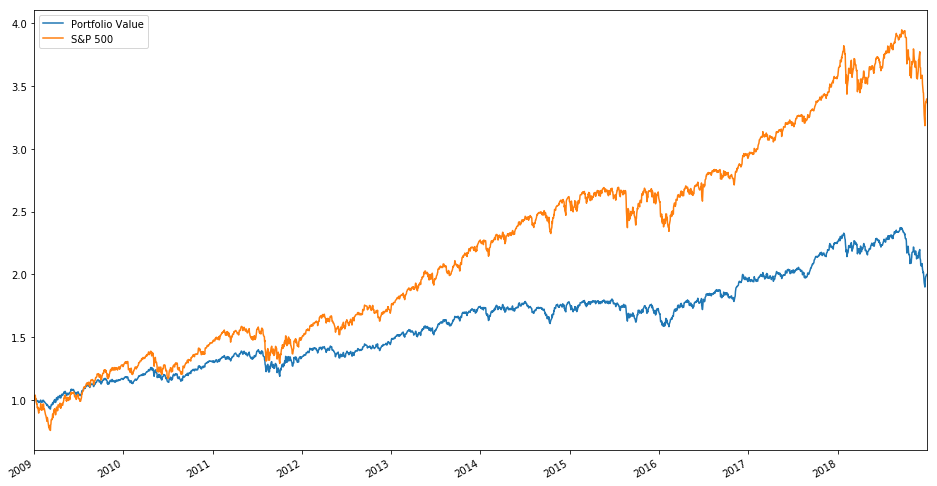

In [205]:
portfolio_value = thestrat.observers[0].value.plot()
df_comp = pd.DataFrame(portfolio_value, columns=['Portfolio Value'], index=get_trading_data('NKE').index)
df_comp = pd.concat([df_comp, spy], axis=1)
df_comp = df_comp / df_comp.ix[0, :]
df_comp.plot(figsize=(16, 9))

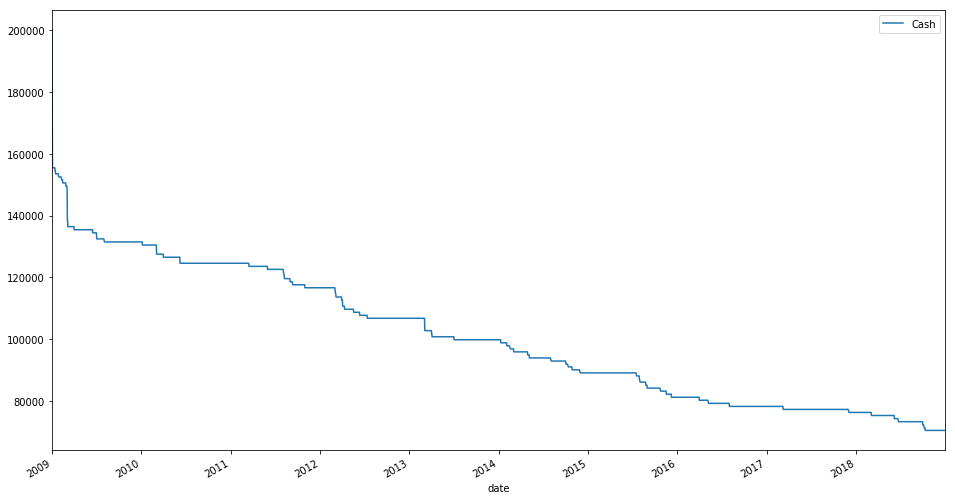

In [206]:
cash = thestrat.observers[0].cash.plot()
df_cash = pd.DataFrame(cash, index=get_trading_data('NKE').index, columns=['Cash'])
df_cash.plot(figsize=(16, 9))

## Next steps

The current implementation performs significantly worse than S&P 500. The following next steps are needed to improve the results:
- **Selling strategy**. We are not selling, just buying and holding. We should implement a selling strategy once a company hits a certain criteria.
- **Size criteria**. Intelligent Investor's revised edition recommends to update the size criteria (1st of the 7 criteria for defensive investors) to only buy stock from companies with sales at least USD 2 billion (instead of USD 100 million). This would significantly change the list of companies passing the criteria.
- **Portfolio allocation**. We are simply purchasing the same amount in USD for every company that passes the criteria. We should implement a way to rank the opportunities and allocate the cash accordingly to the size of the opportunity.
- **Survivor bias**. We are excluding companies which ceased to trade before the end of the simulation. We should include them back, treating the dataframe with trading data (i.e. filling close prices with zero).

We should also investigate why PB ratio criteria actually pull the results down.